# Train Test the Optimum Model and Predict Hold Out Data

___

# Import library and Data Setup
Import necessary library

**Setup the training data and testing data set**

The train.csv and test.csv were split using [export_train_test_set.ipynb](https://github.com/cmxteng/aiforsea-traffic-management/blob/master/export_train_test_set.ipynb) 

It is split into 25% test dataset and 75% train dataset.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('whitegrid')

### Get the Data

**Read in the training csv file and Hold-out test csv file as a DataFrame called trainset and testset respectively.**

In [3]:
trainset = pd.read_csv('train60_075.csv')

In [4]:
testset = pd.read_csv('test60_025.csv')

In [5]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3306164 entries, 0 to 3306163
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 100.9+ MB


In [6]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826542 entries, 0 to 826541
Data columns (total 4 columns):
geohash6     826542 non-null object
day          826542 non-null int64
timestamp    826542 non-null object
demand       826542 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 25.2+ MB


In [7]:
trainset.isnull().values.any()

False

In [8]:
testset.isnull().values.any()

False

### Convert timestamp to time (in hour format) in float
* 15 minute: 0.25 hour
* 30 minute: 0.50 hour
* 45 minute: 0.75 hour

In [9]:
# extract hour and minute from timestamp column for trainset
trainset[['hour','min']] = trainset['timestamp'].str.split(':',expand=True).astype('int64')
trainset['time'] = trainset['hour']+(trainset['min']/60.0)

In [10]:
# extract hour and minute from timestamp column for testset
testset[['hour','min']] = testset['timestamp'].str.split(':',expand=True).astype('int64')
testset['time'] = testset['hour']+(testset['min']/60.0)

In [11]:
trainset.head()

,geohash6,day,timestamp,demand,hour,min,time
0,qp096z,35,20:45,0.105622,20,45,20.75
1,qp03nx,32,10:30,0.081468,10,30,10.50
2,qp03zt,40,2:45,0.221554,2,45,2.75
3,qp09kt,13,6:45,0.038832,6,45,6.75
4,qp0djm,38,2:30,0.046513,2,30,2.50


In [12]:
testset.head()

,geohash6,day,timestamp,demand,hour,min,time
0,qp09cu,47,9:30,0.021819,9,30,9.50
1,qp03mr,19,1:45,0.001785,1,45,1.75
2,qp09ds,30,7:45,0.007478,7,45,7.75
3,qp093v,37,22:0,0.013631,22,0,22.00
4,qp09b0,50,3:0,0.158475,3,0,3.00


### Decode Geohash6

In [13]:
import geohash

In [14]:
trainset['coordinate'] = trainset.geohash6.apply(lambda c: geohash.decode(c))

trainset['coordinate'].tolist()
trainset[['latitude', 'longitude']] = pd.DataFrame(trainset['coordinate'].tolist(), index=trainset.index)

In [15]:
testset['coordinate'] = testset.geohash6.apply(lambda c: geohash.decode(c))

testset['coordinate'].tolist()
testset[['latitude', 'longitude']] = pd.DataFrame(testset['coordinate'].tolist(), index=testset.index)

In [16]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3306164 entries, 0 to 3306163
Data columns (total 10 columns):
geohash6      object
day           int64
timestamp     object
demand        float64
hour          int64
min           int64
time          float64
coordinate    object
latitude      float64
longitude     float64
dtypes: float64(4), int64(3), object(3)
memory usage: 252.2+ MB


In [17]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826542 entries, 0 to 826541
Data columns (total 10 columns):
geohash6      826542 non-null object
day           826542 non-null int64
timestamp     826542 non-null object
demand        826542 non-null float64
hour          826542 non-null int64
min           826542 non-null int64
time          826542 non-null float64
coordinate    826542 non-null object
latitude      826542 non-null float64
longitude     826542 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 63.1+ MB


In [18]:
trainset.corr()

,day,demand,hour,min,time,latitude,longitude
day,1.000000,0.023104,0.000618,-0.000009,0.000617,-0.003383,0.009859
demand,0.023104,1.000000,-0.085214,-0.002767,-0.085246,-0.021967,-0.032511
hour,0.000618,-0.085214,1.000000,0.002470,0.999088,0.023687,-0.080338
min,-0.000009,-0.002767,0.002470,1.000000,0.045171,-0.000539,-0.000340
time,0.000617,-0.085246,0.999088,0.045171,1.000000,0.023640,-0.080271
latitude,-0.003383,-0.021967,0.023687,-0.000539,0.023640,1.000000,0.139861
longitude,0.009859,-0.032511,-0.080338,-0.000340,-0.080271,0.139861,1.000000


In [19]:
testset.corr()

,day,demand,hour,min,time,latitude,longitude
day,1.000000,0.022989,0.001442,0.001068,0.001486,-0.004502,0.009469
demand,0.022989,1.000000,-0.084338,-0.002538,-0.084358,-0.019351,-0.032456
hour,0.001442,-0.084338,1.000000,0.003143,0.999089,0.023482,-0.079005
min,0.001068,-0.002538,0.003143,1.000000,0.045815,0.000575,-0.000453
time,0.001486,-0.084358,0.999089,0.045815,1.000000,0.023482,-0.078942
latitude,-0.004502,-0.019351,0.023482,0.000575,0.023482,1.000000,0.139317
longitude,0.009469,-0.032456,-0.079005,-0.000453,-0.078942,0.139317,1.000000


___

## Setting up the Train Test Data

**Get data ready for the regression models.**


Check data info again

In [20]:
X_train = trainset[['time','day','latitude','longitude']].values
y_train = trainset['demand'].values

In [21]:
X_test = testset[['time','day','latitude','longitude']].values
y_test = testset['demand'].values

In [22]:
print(X_train.shape)
print(y_train.shape)

(3306164, 4)
(3306164,)


In [23]:
print(X_test.shape)
print(y_test.shape)

(826542, 4)
(826542,)


___

# Random Forest Model

## New Random Forest Model

Set up a new parameter for the new random forest model based on the grid search, **n_estimator =30**, **max_depth = 80** and **min_samples_leaf = 2**.

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
new_forest = RandomForestRegressor(n_estimators=30,max_depth=80,min_samples_leaf=2, n_jobs= -1)

In [29]:
new_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Cross Validation for new Random Forest model

In [17]:
from sklearn.model_selection import cross_val_score

In [24]:
new_scores_rfr = cross_val_score(new_forest, X_train, y_train, cv=10, scoring='explained_variance')

In [23]:
print('Scores for k=10 fold validation:',new_scores_rfr)
print("Estimated EV: %0.4f (+/- %0.4f)" % (new_scores_rfr.mean(), new_scores_rfr.std() * 2))

Scores for k=10 fold validation: [0.84746725 0.74074462 0.75701145 0.81404575 0.81099208 0.85346711
 0.83748028 0.78328248 0.77225433 0.80119644]
Estimated EV: 0.8018 (+/- 0.7270)


In [18]:
new_rmse_rfr = cross_val_score(new_forest, X_train, y_train, cv=10,scoring='neg_mean_squared_error')

In [19]:
print('Scores for k=10 fold validation:',new_rmse_rfr)
print("MSE: %0.4f (+/- %0.4f)" % (new_rmse_rfr.mean(), new_rmse_rfr.std() * 2))

Scores for k=10 fold validation: [-0.00394365 -0.00680675 -0.006464   -0.00476699 -0.00505391 -0.00392782
 -0.00463169 -0.00566412 -0.00736383 -0.00627875]
RMSE: -0.0055 (+/- 0.0023)


In [23]:
math.sqrt(-(new_rmse_rfr.mean()))

0.0740955552641079

### New Prediction for New Random Forest test dataset

In [30]:
# Predicting a random forest result
new_forest_pred = new_forest.predict(X_test)
new_forest_score = new_forest.score(X_test, y_test)
print(new_forest_score)

0.9597607166170052


In [31]:
# calculate forest MAE, MSE, RMSE!
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, new_forest_pred))
print('MSE:', metrics.mean_squared_error(y_test, new_forest_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, new_forest_pred)))

MAE: 0.020514490964067184
MSE: 0.0010255407845916633
RMSE: 0.03202406570989485


### Residuals

Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(0, 30)

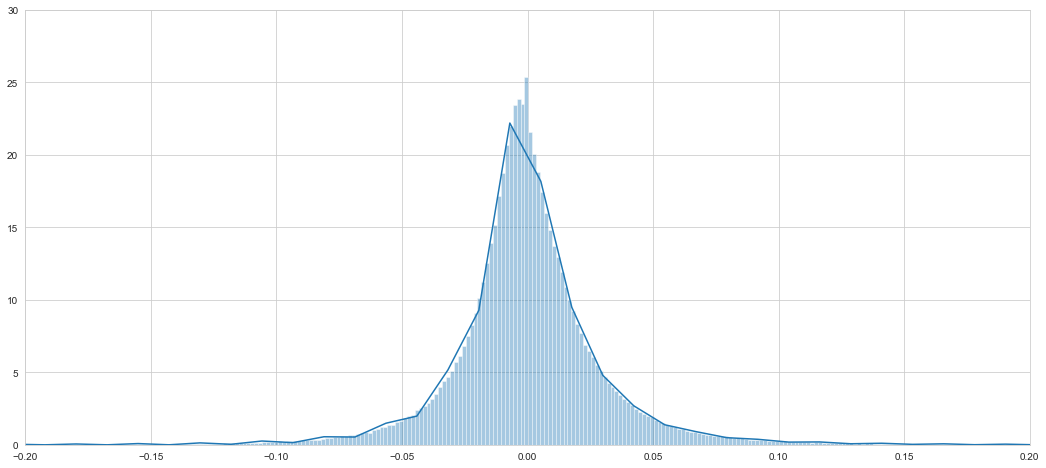

In [32]:
plt.figure(figsize=(18,8))
sns.distplot((y_test-new_forest_pred),bins=1000);
plt.xlim(-0.2,0.2)
plt.ylim(0,30)

The table shown is the results of Random Forest:

| Models                 | Random Forest |
|------------------------|---------------|
|CV Train RMSE:          | 0.0741        |
|Prediction RMSE:        | 0.0320        |

___

## eXtreme Gradient Boost - XGBoost model

### Train the XGBoost model

To start, import the XGBoost library and neccessary library. 

In [33]:
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

### The best parameters from tuning are:
* gamma = 0
* min_child_weight = 5
* max_depth = 60
* subsample = 0.6
* colsample_bytree = 0.8
* learning_rate = 0.1
* n_estimators = 200
* reg_alpha = 0.2


In [34]:
xgb9 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=200,
                    #nthread=4,
                    n_jobs=-1,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27)

In [35]:
xgb9.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=60,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.2,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.6, tree_method='exact')

### Cross Validation for new optimum parameter of XGBoost model
This is to test performance and overfitting using k-fold validation; here we take 10 folds, cv = 10.

In [14]:
scores_xgb = cross_val_score(xgb9, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

Scores for k=10 fold validation: [-0.00170116 -0.00169112 -0.00170516 -0.00169    -0.00171038 -0.00171042
 -0.00170086 -0.00168206 -0.00171377 -0.00174906]
Train MSE: -0.0017 (+/- 0.0000)
Train RMSE: 0.0413


In [17]:
print('Scores for k=10 fold validation:',scores_xgb)
print("Train MSE: %0.6f (+/- %0.6f)" % (scores_xgb.mean(), scores_xgb.std() * 2))
print("Train RMSE: %0.6f" % math.sqrt(-(scores_xgb.mean())))

Scores for k=10 fold validation: [-0.00170116 -0.00169112 -0.00170516 -0.00169    -0.00171038 -0.00171042
 -0.00170086 -0.00168206 -0.00171377 -0.00174906]
Train MSE: -0.001705 (+/- 0.000035)
Train RMSE: 0.041296


### Prediction for test dataset

In [60]:
xgb9_score = xgb9.score(X_test, y_test)
print("Prediction Score: %0.6f" % xgb9_score)

Prediction Score: 0.934022


In [61]:
# Predicting a rgb result
xgb9_pred = xgb9.predict(X_test)
from sklearn import metrics
print('Test MAE:', metrics.mean_absolute_error(y_test, xgb9_pred))
print('Test MSE:', metrics.mean_squared_error(y_test, xgb9_pred))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb9_pred)))

Test MAE: 0.026627274867198056
Test MSE: 0.0016815251767656482
Test RMSE: 0.04100640409455148


The cross validation of test RMSE value is close to train RMSE.

| Models                 | Random Forest | **XGBoost** |
|------------------------|---------------|-------------|
|CV Train RMSE:          | 0.0741        | **0.0413**  |
|Prediction RMSE:        | 0.0320        | **0.0410**  |


### Residuals

Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(0, 30)

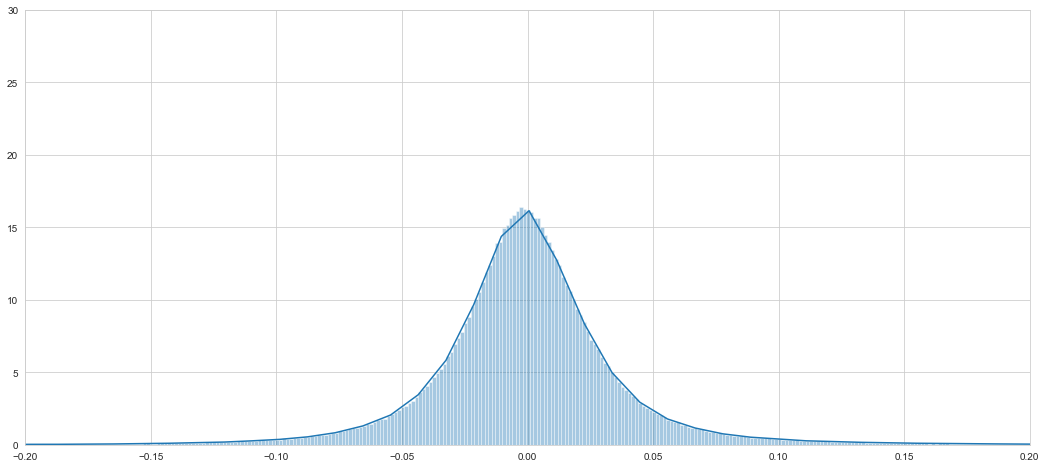

In [62]:
plt.figure(figsize=(18,8))
sns.distplot((y_test-xgb9_pred),bins=1000);
plt.xlim(-0.2,0.2)
plt.ylim(0,30)

### Visualize the features importance
There are features included: 
1. time, f0
2. day, f1
3. latitude, f2
4. longtude, f3

The result shows **time is the most important feature**.

In [73]:
print(xgb9.feature_importances_)

[0.3347544  0.23391248 0.23597266 0.19536044]


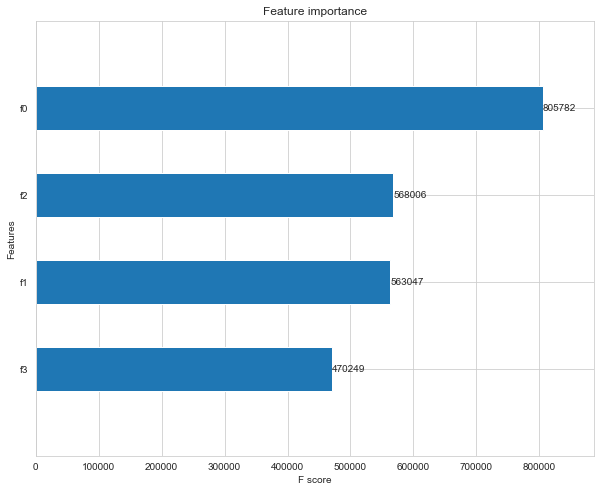

In [87]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
xgb.plot_importance(xgb9, height=0.5, ax=ax)
plt.show()

___

## Test with Hold out day 61 test data

In [36]:
holdout = pd.read_csv('holdout.csv')

In [37]:
# extract hour and minute from timestamp column
holdout[['hour','min']] = holdout['timestamp'].str.split(':',expand=True).astype('int64')
holdout['time'] = holdout['hour']+(holdout['min']/60.0)

In [38]:
# Decode geohash6
holdout['coordinate'] = holdout.geohash6.apply(lambda c: geohash.decode(c))
holdout['coordinate'].tolist()
holdout[['latitude', 'longitude']] = pd.DataFrame(holdout['coordinate'].tolist(), index=holdout.index)

In [39]:
Xh_test = holdout[['time','day','latitude','longitude']].values
yh_test = holdout['demand'].values

### Random Forest model

In [40]:
# Predicting a random forest result
h_forest_pred = new_forest.predict(Xh_test)
h_forest_score = new_forest.score(Xh_test, yh_test)
print(h_forest_score)

0.8000861202151122


In [41]:
# calculate forest MAE, MSE, RMSE!
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(yh_test, h_forest_pred))
print('MSE:', metrics.mean_squared_error(yh_test, h_forest_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(yh_test, h_forest_pred)))

MAE: 0.04067192885029519
MSE: 0.0053586756215718
RMSE: 0.07320297549670915


### XGBoost model

In [42]:
h_xgb9_score = xgb9.score(Xh_test, yh_test)
print("Prediction Score: %0.6f" % h_xgb9_score)

Prediction Score: 0.821407


In [44]:
# Predicting a rgb result
h_xgb9_pred = xgb9.predict(Xh_test)
from sklearn import metrics
print('Test MAE:', metrics.mean_absolute_error(yh_test, h_xgb9_pred))
print('Test MSE:', metrics.mean_squared_error(yh_test, h_xgb9_pred))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(yh_test, h_xgb9_pred)))

Test MAE: 0.04067170163242839
Test MSE: 0.004787179211580814
Test RMSE: 0.06918944436531352


___